<a href="https://colab.research.google.com/github/Rupesh0Poudel/Numerical_Introductory_Seminar/blob/main/Software_AG_matrix_form.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 537 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


Install yfinance to download stock data

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import time


[*********************100%***********************]  1 of 1 completed
Time taken to download the data and plot returns: 0.4400808811187744


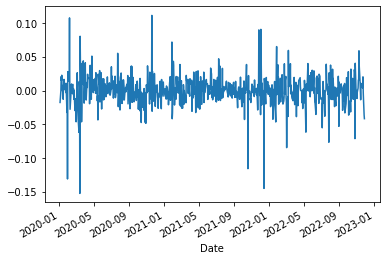

In [9]:
start1 = time.time() #start countdown
software = yf.download("SOW.DE", start = "2020-1-1", end = "2022-11-30")
St = software['Adj Close'] #extract the adjusted close from the apple 

initial_price = St[-1] # only extract the final price of the series. The simulation will start from this value
returns = St.pct_change()
ln_returns = np.log(1+ returns) # this and the above line is a python way for S_t / S _{t-1}
log_returns = ln_returns[1:744] # as the first term with index 0 will be NaN

log_returns.plot()
end1 = time.time() # end countdown

print('Time taken to download the data and plot returns:', end1-start1)


# New Section

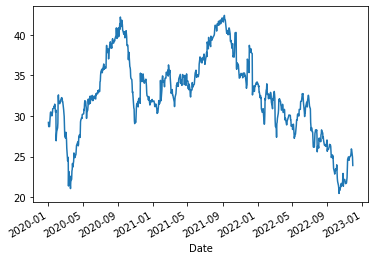

In [10]:
St.plot()

In [11]:
M = 100000 #100,000 simulations
N = 40 #40 trading days 
nudt = 0 # assuming that only movement of the stock comes from innovation terms
volsdt = log_returns.std() #using historical volatility. 
avg = log_returns.mean() #the assumption of 0 was made because the mean here returns value close to 0
print('The average is:',avg, 'and the standard deviation is:', volsdt)
lnS = np.log(initial_price)


The average is: -0.0002692923353706591 and the standard deviation is: 0.02256021224052601


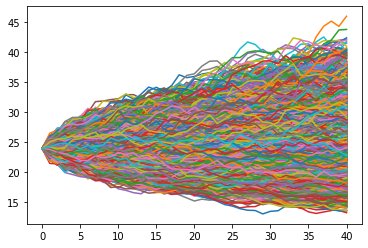

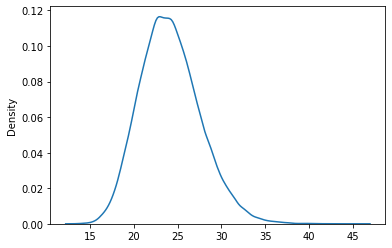

In [12]:

start21 = time.time()
np.random.seed(100) # a seed is selected for result reproduction 
Z = np.random.normal(size=(N, M)) # 2 dimensional matrix of random numbers. Replace z with something else for sensitivity check
end_prng = time.time() # checking how much random number generation took
delta_lnSt = nudt + volsdt*Z # i did assume drift term to be 0. The diffusion term guides the process
lnSt = lnS + np.cumsum(delta_lnSt, axis=0) #converting to the logarithm term allows the result to be calculated with cumsum only, axis = 0 and axis = 1 gives different results
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) ) # Here, only the initial value is being added to the price progression, so that when plot is drawn eventually, the plot starts from the same point
ST = np.exp(lnSt) #converting back to original term again. Entire simulation matrix is converted.
plt.plot(ST) # plotting the price path for all simulations
plt.show() #to avoid the message <--------> for 100,000 lines
final_day = ST[-1]
sns.kdeplot(final_day) #kernel density plot under default setting


end21 = time.time() #checking how much time the simulation took 


In [13]:
print ('The time taken by benchmark simulation is:',end21-start21, 'of which the time taken to generate random number is:', end_prng-start21)



The time taken by benchmark simulation is: 120.30843687057495 of which the time taken to generate random number is: 0.3069469928741455


In [14]:
mean0 = final_day.mean() #mean of the 100,000 prices for the final day is taken which will be the price I am looking for
se0 = final_day.std() #but this price will come with standard deviation
print('The average is:',mean0,'and the standard deviation is:',se0, 'The number of simulation:',len(final_day))

print('The maximum is:',final_day.max(),'and the minimum is', final_day.min()) #this shows what is the maximum and the minimum the simulation generated.
skew0 = stats.skew(final_day) #skewness and kurtosis of the final day price is checked
kurtosis0 = stats.kurtosis(final_day)
print('The skewness is :',skew0,'and the kurtosis is:', kurtosis0)
from sklearn.metrics import mean_squared_error #scikitlearn will allow to calculate mean squared error from predicted and true values
np.random.seed(0)
y_true = np.random.normal(mean0,se0, size = 100000) # true value here is the normally distributed sample with the same size as number of trials, with same mean and standard deviation as the price matrix for 100,000 simulations on the final day
y_pred = final_day #the actual price series on the final day


y1 = np.sort(y_true) #the sorting to ensure that MSE is being calculated for the n'th smallest point of true plot with n'th smallest point of the predicted plot
y2 = np.sort(y_pred)
mse1 = mean_squared_error(y1, y2) #to give mean squared error
rmse1 = mean_squared_error(y1, y2, squared = False) #to give root mean squared error
print('The mean squared error is:', mse1, 'and the root mean squared error is:', rmse1)


import numpy as np 
from scipy.stats import t

x =final_day

m = x.mean() 
s = x.std() 
dof = len(x)-1 #degree of freedom 
confidence = 0.95 #95% confidence interval is taken

t_crit = np.abs(t.ppf((1-confidence)/2,dof)) # the critical value that replaces z in the formula

print('The 95 % CI is (',m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x)), ')') 


The average is: 24.15281685085458 and the standard deviation is: 3.4584045125513723 The number of simulation: 100000
The maximum is: 45.93156541436398 and the minimum is 13.238885346462462
The skewness is : 0.434928288746307 and the kurtosis is: 0.3402634207442752
The mean squared error is: 0.12766402511403407 and the root mean squared error is: 0.35730102870553576
The 95 % CI is ( 24.1313815720412 24.174252129667963 )


In [15]:
stats.kstest(y2, 'norm') # Kolmogorov-Smirnov Test, need at-least 0.05 or more of p-value for normality

KstestResult(statistic=1.0, pvalue=0.0)

In [16]:
stats.anderson(y2) #Anderson Test. Need 0.787 or less of test statistic for normality under 95% confidence interval


AndersonResult(statistic=191.24869097063493, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

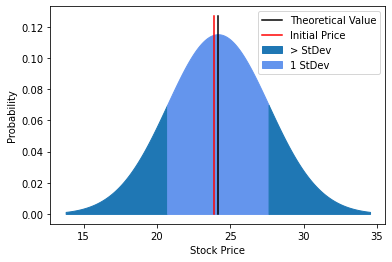

In [17]:
x1 = np.linspace(mean0-3*se0, mean0-1*se0, 100) #this is only to draw the initial and final position of the stock price in comparsion to the standard deviation.
x2 = np.linspace(mean0-1*se0,mean0+1*se0,100)
x3 = np.linspace(mean0+1*se0,mean0+3*se0,100)

s1 = stats.norm.pdf(x1, mean0, se0) 
s2 = stats.norm.pdf(x2, mean0, se0)
s3 = stats.norm.pdf(x3, mean0, se0)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev') 
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev') 
plt.fill_between(x3, s3, color='tab:blue') 

plt.plot([mean0,mean0],[0, max(s2)*1.1], 'k', label='Theoretical Value') #black line plots the theoretical value 
plt.plot([initial_price,initial_price],[0, max(s2)*1.1], 'r', label='Initial Price') # red line plots the initial price

plt.ylabel("Probability") # show the y- axis label
plt.xlabel("Stock Price") # show the x- axis label
plt.legend() # show the legend
plt.show() #show the plot